In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed as set_seed, randint
from scipy import stats
from jax.interpreters.xla import DeviceArray
from jax import grad, jit

DeviceArray.abs = np.abs
DeviceArray.pipe = lambda self, func: func(self)

plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'Dark2'

# Definitions

In [2]:
def classify_with_hyperplane(X, w) -> '(X.shape[0],)':
    return np.sign(X @ w)

def classify_with_tiles(X, B, c) -> '(X.shape[0],)':
    tiles = (X[:, :, np.newaxis] > B[np.newaxis, :, :]).sum(axis=2)
    tiles_flat = tiles @ np.array([(k+1)**i for i in range(d)])
    return c[tiles_flat]

def sigmoid(x) -> 'x.shape':
    return 1/(1 + np.exp(-x))

def make_normal_unit_vector(d) -> '(d,)':
    v = np.append(-1, np.ones(d-1))
    return v/np.sqrt(v@v)

def generate_data(N, d, sep=0, dist=stats.norm()) -> 'X: (N, d); y: (N,)':
    X = dist.rvs(size=(N, d))
    w = make_normal_unit_vector(d)
    y = np.sign(X @ w)
    X += sep*y[:, np.newaxis]*w
    return X, y

def generate_random_boundaries(X, d, k) -> '(d, k)':
    dist = stats.uniform(loc=X.min(), scale=X.max() - X.min())
    sample = lambda: np.array(dist.rvs(size=(1, k))).sort()
    return np.concatenate([sample() for _ in range(d)])

def generate_random_reconstruction_points(X, M, d) -> '(M, d)':
    dist = stats.uniform(loc=X.min(), scale=X.max() - X.min())
    return dist.rvs(size=(M, d))

def plot_2d_problem(X, y=None, B=None, RX=None):
    x = np.linspace(X.min(), X.max(), 100)
    plt.scatter(*X.T, c=y, alpha=0.25)
    plt.plot(x, x, 'k--', alpha=0.15)
    if B is not None:
        plt.vlines(B[0], X[:, 1].min(), X[:, 1].max(), colors='k', linestyles='dashed')
        plt.hlines(B[1], X[:, 0].min(), X[:, 0].max(), colors='k', linestyles='dashed')
        
    if RX is not None:
        plt.scatter(*RX.T, s=100, marker='X', c='black')
    
def calc_tile_centroids(B, X) -> '(M, d)':
    B_ = np.hstack([X.min(axis=0)[:, np.newaxis],
                    B,
                    X.max(axis=0)[:, np.newaxis]])
    RX = (B_[:, :-1] + B_[:, 1:])/2
    return np.stack(np.meshgrid(*RX), axis=-1).reshape(-1, X.shape[1])

def calc_min_reconstruction_tiling(RX) -> '(M, d)':
    M_sqrt = np.sqrt(RX.shape[0]).astype('int32')
    Z_coords = sort_dimensions(RX).reshape((M_sqrt, M_sqrt, d)).mean(axis=1).T
    return np.stack(np.meshgrid(*Z_coords), axis=2).reshape(-1, 2), Z_coords

def calc_boundaries_from_tile_centroids(Z_coords) -> '(d, k)':
    return (Z_coords[:, 1:] + Z_coords[:, :-1])/2

def sort_dimensions(A) -> '(*A.shape)':
    return A[A.argsort(axis=0), np.arange(A.shape[1])]

In [3]:
seed: 'global numpy seed' = 0
set_seed(seed)

N: 'sample size' = 2_000
d: 'problem dimension' = 2
R: 'bit rate per dimension' = 2
S: 'sample (N, d) (N,)' = generate_data(N, d, sep=0.25, dist=stats.norm())
X, y = S
w: 'unit vector normal to class. boundary (d,)' = make_normal_unit_vector(d)
k: 'number of boundaries (roots) per dimension' = 2**R - 1
M: 'number of tiles' = 2**(R*d)
RX: 'reconstruction points (M,)' = generate_random_reconstruction_points(X, M, d)
Z, Z_coords = calc_min_reconstruction_tiling(RX)
B: 'boundaries matrix (d, k)' = calc_boundaries_from_tile_centroids(Z_coords)
c: 'label of each tile (M,)' = classify_with_hyperplane(Z, w)

/home/dsevero/miniconda3/envs/dsevero.com/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# 2D Problem

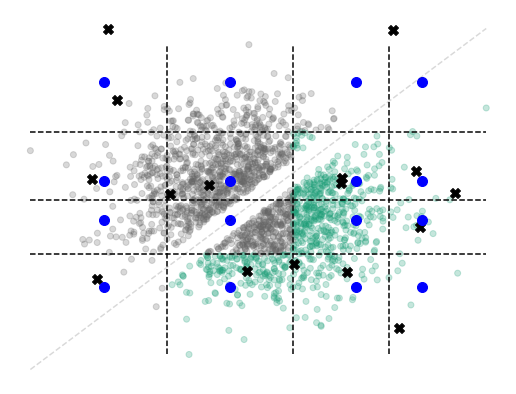

In [4]:
plt.figure(figsize=(9, 7))
y_tile = classify_with_tiles(X, B, c)
plot_2d_problem(X, y_tile, B, RX)
plt.scatter(*Z.T, s=100, c='blue')
plt.axis('off');